In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import minimize

In [2]:
plt.rcParams['figure.figsize'] = [20, 15]

In [3]:
#Select three ETFs and download their price information from Yahoo Finance.
#VOOG S&P 500 growth
#VYM Large cap high dividend yield
#BLV Long term bond

In [4]:
#A start date of 1/1/2011 was chosen because this is the first year for which data for all three ETFs is available
start_date = datetime(2011, 1, 1) #set start date
end_date = datetime(2021, 6, 30) #set end date

In [5]:
etf1 = yf.download(['VOOG','VYM','BLV'], start = start_date, end = end_date)['Adj Close']
etf1.reset_index(inplace=True)
etf1['Year']=etf1['Date'].dt.year
etf1['Month']=etf1['Date'].dt.month
etf1.rename(columns={'VOOG':'fund1','VYM':'fund2','BLV':'fund3'},inplace=True)
etf1

[*********************100%***********************]  3 of 3 completed


,Date,fund3,fund1,fund2,Year,Month
0,2011-01-03,49.978466,51.097961,30.594837,2011,1
1,2011-01-04,49.845905,50.882359,30.609232,2011,1
2,2011-01-05,49.170414,51.097961,30.645247,2011,1
3,2011-01-06,49.284073,51.089336,30.602045,2011,1
4,2011-01-07,49.523941,51.028954,30.566027,2011,1
...,...,...,...,...,...,...
2635,2021-06-23,102.110588,258.059021,103.500000,2021,6
2636,2021-06-24,102.290169,259.299988,104.339996,2021,6
2637,2021-06-25,101.681595,259.320007,104.959999,2021,6
2638,2021-06-28,102.360001,261.809998,104.550003,2021,6


In [6]:
etf1.sort_values(by=['Date'], inplace=True)

In [7]:
#Calculate the monthly returns of the three ETFs you select.
etf1[['fund1_ret_d','fund2_ret_d','fund3_ret_d']]=etf1[['fund1','fund2','fund3']].pct_change()
etf1[['fund1_ret_d+1','fund2_ret_d+1','fund3_ret_d+1']]=etf1[['fund1_ret_d','fund2_ret_d','fund3_ret_d']]+1
etf2=etf1[['fund1_ret_d+1','fund2_ret_d+1','fund3_ret_d+1','Year','Month']].groupby(['Year','Month']).prod()
etf2[['fund1_ret_m','fund2_ret_m','fund3_ret_m']]=etf2[['fund1_ret_d+1','fund2_ret_d+1','fund3_ret_d+1']]-1
etf3=etf2[['fund1_ret_m','fund2_ret_m','fund3_ret_m']]
etf3

fund1_ret_m  fund2_ret_m  fund3_ret_m
Year Month                                       
2011 1         0.003207     0.008239    -0.014526
     2         0.032301     0.035022     0.014598
     3         0.005888     0.007095    -0.003769
     4         0.031535     0.040153     0.027824
     5        -0.008982    -0.005856     0.029703
...                 ...          ...          ...
2021 2         0.000087     0.045719    -0.042107
     3         0.028592     0.069421    -0.032856
     4         0.067924     0.025522     0.018323
     5        -0.008767     0.030288     0.003268
     6         0.057723    -0.016955     0.036572

[126 rows x 3 columns]

In [8]:
#Pick  a  target  annualized  volatility  of  the  portfolio  of  the  three  ETFs.  
#Search  and  report  the weights on the three ETFs that maximize the average return of the portfolio 
#of the three ETFs for your target volatility level. 
#(search_weight function in the example code can be used to search the weights) 
#(If you pick a too high or too low target volatility, the search might be unsuccessful. 
#Then, please adjust your target volatility and make sure the search is successful.)

#Calculate current return and volatility of equally weighted portfolio
returns=etf3
weight=[0.333,0.333,0.333]
returns.multiply(weight)
returns.multiply(weight).sum(axis=1)
def pret(weight):
    pret1=returns.multiply(weight).sum(axis=1)
    pret1_mean=pret1.mean()
    return pret1_mean
pret(weight)

0.010089847632325401

In [9]:
pret(weight)
def pvol(weight):      
    pret1=returns.multiply(weight).sum(axis=1)
    pret1_vol=pret1.std()*np.sqrt(12)
    return pret1_vol
pvol(weight) 

0.08644663420249178

In [10]:
target_vol=[0.1]
no_fund=3
weight=[0.25,0.25,0.5]
returns=etf3

def search_weight(weight, returns, target_vol, no_fund):

    def pret(weight):
        pret1=returns.multiply(weight).sum(axis=1)
        pret1_mean_flip=-pret1.mean()
        return pret1_mean_flip

    def pvol(weight,target_vol):
        pret1=returns.multiply(weight).sum(axis=1)
        pret1_vol=pret1.std()*np.sqrt(12)-target_vol
        return pret1_vol

    def sumweight(weight):
        return weight.sum()-1

    solve1=minimize(pret, weight,constraints=({"fun": pvol, "type": "eq", 'args': target_vol},{"fun": sumweight,"type": "eq"}), bounds=[(0,1)]*no_fund)

    weight_select=solve1.x
    portfolio_ret=-solve1.fun*12
    success=solve1.success

    return portfolio_ret, weight_select, success;

In [11]:
weight=[0,0,0]
returns=etf3
target_vol=[0.09]
no_fund=3

In [12]:
portfolio_ret,weight_select,success=search_weight(weight, returns, target_vol, no_fund)

In [13]:
portfolio_ret

0.12623419404516698

In [14]:
weight_select

array([0.4248134 , 0.26702736, 0.30815924])

In [15]:
#As you progress in your career, your income is likely to increase over time. 
#Thus, you could put more  money  each  month  into  your  investment  portfolio.  
#Please  select  a  growth  rate  for  your monthly  payment  and  revise  the  accountbalance  
#function  to  incorporate  the  monthly  payment growth  into  the  function.  
#(For  example,  if  you  think  you  will  put  0.1%  more  money  monthly overtime  and  the  
#first  monthly  payment  is  $200,  then  your  second  monthly  payment  is  $200  * (1+0.1%) 
#and the Nth monthly payment is $200 * (1+0.1%) ^N.)

In [16]:
#hint: we just need to change the following part of the accountbalance function:
#value=0
#balance=[]        
#for i in range (no_month):        
#value=(value+monthlypayment)*(1+pret_sim2[i,:])        
#balance.append(value)
#balance1=pd.DataFrame(balance)

age_current = 31
age_retire=65
monthlypayment=500
no_simulation=100
annualfee=0.0035
pmtincrease=0.005
#pmtincrease is a variable added for expected increase in monthly contributions
#portfolio_ret and target_vol are values recorded previously

#The function to calculate accountbalance        
def accountbalance(age_current, age_retire, monthlypayment, no_simulation, annualfee, pmtincrease, portfolio_ret, target_vol):

    no_month=(age_retire-age_current)*12

#simulate returns using random numbers from normal distribution using portfolio return and target vol from previous calculation
    pret_sim1=np.random.normal(portfolio_ret/12,target_vol/np.sqrt(12),size=(no_month,no_simulation))

#take into account advisory fees
    pret_sim2=pret_sim1-annualfee/12

#simulate account balance over time
##(For  example,  if  you  think  you  will  put  0.1%  more  money  monthly overtime  and  the  
#first  monthly  payment  is  $200,  then  your  second  monthly  payment  is  $200  * (1+0.1%) 
#and the Nth monthly payment is $200 * (1+0.1%) ^N.)
    value=0
    balance=[]
    
    for i in range (no_month):
        value=(value+monthlypayment*(1+pmtincrease)**i)*(1+pret_sim2[i,:])
        balance.append(value)

    balance1=pd.DataFrame(balance)

    balance1['month_no']=balance1.index+1
    
    #Reshape the balance1 file
    balance2=pd.melt(balance1, id_vars=['month_no'], var_name='sim_no', value_name='balance')
    
#We set the median account balance in each month as the balance under normal market condition
#With 50% chance, the account balance is at least this amount
    normal1=balance2[['month_no','balance']].groupby(['month_no']).quantile(0.5)
    normal1['balance_m']=normal1['balance']/1000000
#We set the 10th percentile account balance in each month as the balance under weak market condition
#With 90% chance, the account balance is at least this amount
    weak1=balance2[['month_no','balance']].groupby(['month_no']).quantile(0.1)
    weak1['balance_m']=weak1['balance']/1000000
    
    return normal1,weak1;

In [17]:
#accountbalance(age_current, age_retire, monthlypayment, no_simulation, annualfee, pmtincrease, portfolio_ret, target_vol)
age_current=31
age_retire=60
monthlypayment=500
no_simulation=1000
annualfee=0.0035
pmtincrease=0.005

normal1,weak1=accountbalance(age_current, age_retire, monthlypayment, no_simulation, annualfee, pmtincrease, portfolio_ret, target_vol)

In [18]:
normal1

,balance,balance_m
month_no,,
1,5.051694e+02,0.000505
2,1.019004e+03,0.001019
3,1.538273e+03,0.001538
4,2.063753e+03,0.002064
5,2.600028e+03,0.002600
...,...,...
344,2.599228e+06,2.599228
345,2.627774e+06,2.627774
346,2.648359e+06,2.648359


In [19]:
weak1

,balance,balance_m
month_no,,
1,4.881164e+02,0.000488
2,9.804329e+02,0.000980
3,1.475120e+03,0.001475
4,1.975341e+03,0.001975
5,2.478839e+03,0.002479
...,...,...
344,1.701631e+06,1.701631
345,1.701761e+06,1.701761
346,1.711657e+06,1.711657


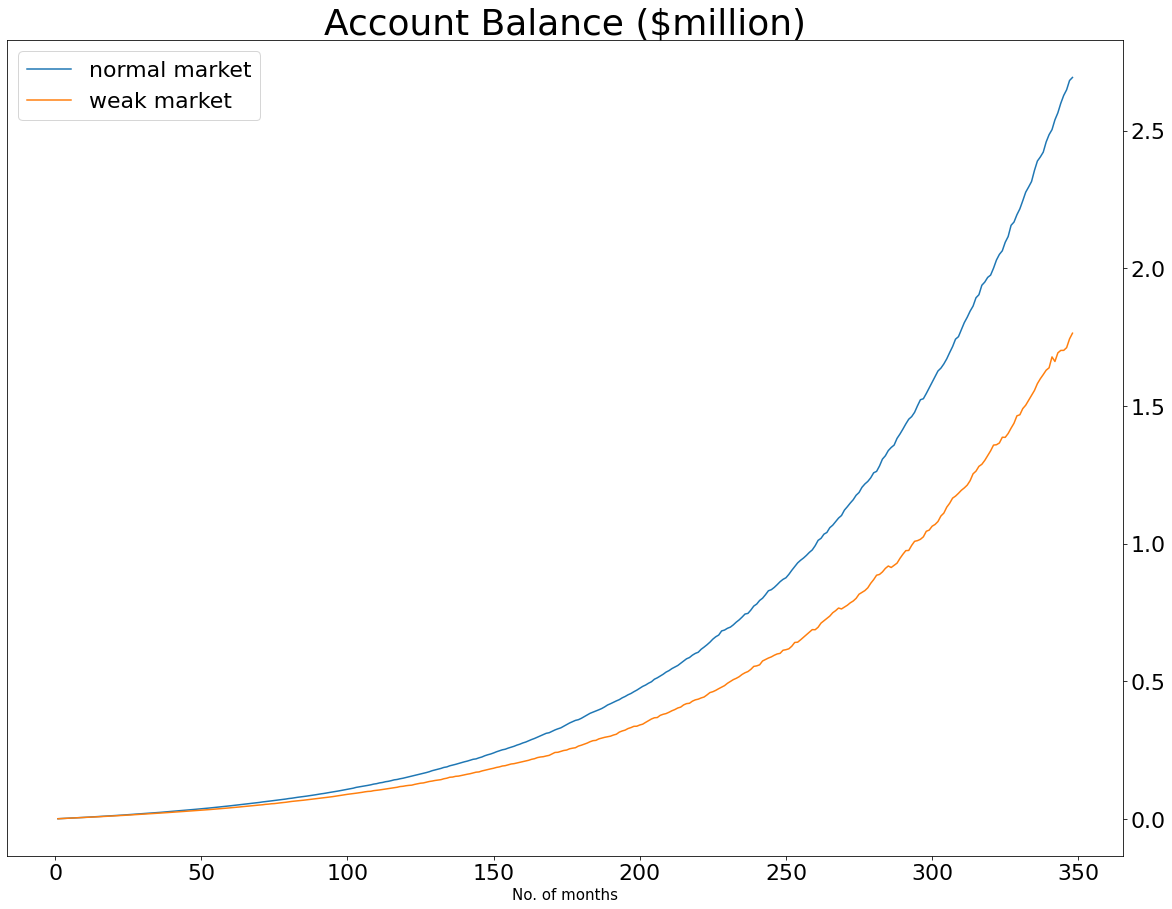

In [20]:
#Generate and report the figure showing your account balance over time under normal and 
#weak market  conditions  after  incorporating  the  monthly  payment  growth.  
#The  calculation  should  be based on the three ETFs you select in question 1 and the target volatility 
#and weights in question 3. (Please free to select the values for all other relevant parameters, 
#such as current age, retirement age, monthly payment, number of simulations, etc.)
plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = True
plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = False
plt.plot(normal1['balance_m'],label="normal market")
plt.plot(weak1['balance_m'],label='weak market')
plt.xlabel("No. of months", size=15)
plt.title("Account Balance ($million)",size=36)
plt.xticks(size=22)
plt.yticks(size=22)
plt.legend(fontsize=22)

In [21]:
#In this example from start to finish, we see that using data from the funds VOOG, VYM, and BLV 
#with a start date of 1/1/11 and finish date of 6/30/21, there is a:
#Portfolio return of 0.010089847632325401
#and portfolio volatility of 0.08644663420249178
#Considering and equal weight portfolio
#
#With a target volatility of 0.09, there is a portfolio return of 0.12623419404516698
#with the following weights for each fund:([0.4248134 , 0.26702736, 0.30815924])
#
#Using the following inputs in the account balance function:
#age_current=31
#age_retire=60
#monthlypayment=500
#no_simulation=1000
#annualfee=0.0035
#pmtincrease=0.005
#
#We see returns approaching $2.7 million and $1.7 million in normal and weak markets, respectively.